In [75]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error

# Graphing
from graph_config import plt
import seaborn as sns

import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


In [2]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET_PATH / filename)

df_tt_og = load_data('Turbine_telemetry.csv')
# df_rd = load_data('Residential_demand.csv')
# df_wd = load_data('kirkwall_weather.csv')

df_tt_og['Timestamp'] = pd.to_datetime(df_tt_og['Timestamp'])

df_tt = df_tt_og.copy()

# Cleaning

## Setting Power to NaN when wind speed is fast enough

In [4]:
# Find the minimum wind speed for power production

v_cut_in = df_tt[(df_tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile minimum speed
v_cut_out = df_tt[df_tt['Power_kw'] >= 10]['Wind_ms'].quantile(0.95)

print(f"minimum wind speed for power production: {v_cut_in:.2f} m/s")
print(f"maximum wind speed for power production: {v_cut_out:.2f} m/s")

# Select only rows with Setpoint_kw == 900
# df_tt = df_tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_tt.loc[
    (df_tt['Wind_ms'] >= v_cut_in) & 
    (df_tt['Power_kw'].abs() <= 1e-5) &
    (df_tt['Setpoint_kw'] > 0),
    'Power_kw'
] = np.nan

df_tt[df_tt.isna().any(axis=1)]

# Column Settings
# df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'])
# df_tt['Date'] = df_tt['Timestamp'].dt.date
# df_tt['Time'] = df_tt['Timestamp'].dt.time
# df_tt['Month'] = df_tt['Timestamp'].dt.month

# Clip the power to the setpoint 900 kW
df_tt['Power_kw'] = df_tt['Power_kw'].clip(upper=900)

print(f"turbine telemetry data shape: {df_tt.shape}")

df_tt.head()

minimum wind speed for power production: 5.00 m/s
maximum wind speed for power production: 20.70 m/s
turbine telemetry data shape: (1069636, 4)


,Timestamp,Power_kw,Setpoint_kw,Wind_ms
0,2015-05-28 00:00:23,80.0,900.0,4.9
1,2015-05-28 00:01:23,78.0,900.0,5.4
2,2015-05-28 00:02:23,52.0,900.0,4.9
3,2015-05-28 00:03:23,57.0,900.0,4.6
4,2015-05-28 00:04:23,54.0,900.0,4.6


## Convert to Timeseries For Resampling

In [5]:
ts_tt = df_tt.set_index('Timestamp')
ts_tt = ts_tt.sort_index()

ts_tt_res = ts_tt.resample('30min').mean()

ts_tt_res_17 = ts_tt_res[
    (ts_tt_res.index >= '2017-01-01') &
    (ts_tt_res.index < '2018-01-02')
]

ts_tt_res_17.shape

(17568, 3)

# Analysis

# Are there missing value?

In [6]:
pd.DataFrame(ts_tt_res_17.isna().sum()).rename({0: 'Count'}, axis=1).T


,Power_kw,Setpoint_kw,Wind_ms
Count,1046,1012,1012


## Why Wind has less missing value?

In [7]:
# power is na but wind is not
ts_tt_res_17[(ts_tt_res_17['Power_kw'].isna()) & (ts_tt_res_17['Wind_ms'].notna())]

,Power_kw,Setpoint_kw,Wind_ms
Timestamp,,,
2017-01-12 18:00:00,NaN,900.0,23.556667
2017-01-12 19:00:00,NaN,900.0,23.820000
2017-01-12 19:30:00,NaN,900.0,26.503333
2017-01-12 20:00:00,NaN,900.0,25.410000
2017-01-12 21:30:00,NaN,900.0,25.470000
2017-01-12 22:00:00,NaN,900.0,24.433333
2017-01-13 04:30:00,NaN,900.0,25.343333
2017-01-13 05:30:00,NaN,900.0,23.573333
2017-04-24 03:00:00,NaN,900.0,7.800000


we set power to NaN when wind is high and setpoint is set to 900 that is why there is more NaN value for power. This logic need to be maintain when doing interpolation or filling missing value with scraped wind data

## Check Longest Consecutive NaN Value

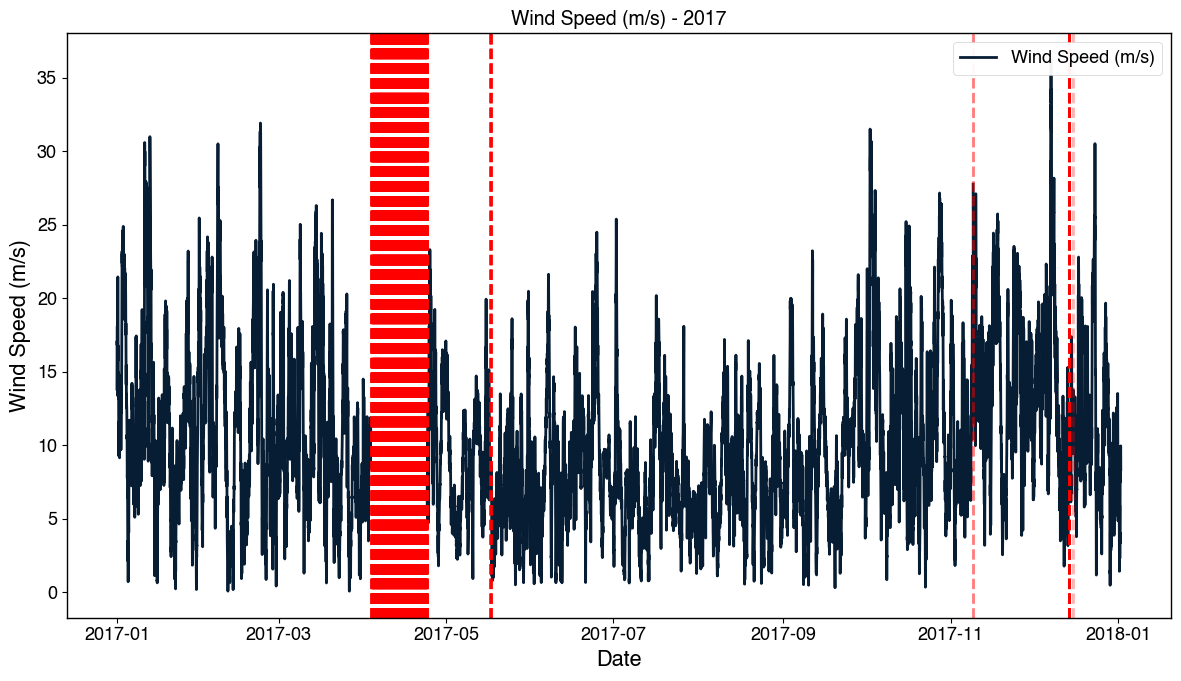

In [8]:
is_nan = ts_tt_res_17['Wind_ms'].isna()

plt.figure(figsize=(12,7))
plt.plot(ts_tt_res_17.index, ts_tt_res_17['Wind_ms'], label='Wind Speed (m/s)')
for t in ts_tt_res_17.index[is_nan]:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.3)
plt.title('Wind Speed (m/s) - 2017')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
wind_is_nan = ts_tt_res_17['Wind_ms'].isna()

start_mask = is_nan & ~is_nan.shift(1, fill_value=False)
end_mask = is_nan & ~is_nan.shift(-1, fill_value=False)

start_times = ts_tt_res_17.index[start_mask]
end_times = ts_tt_res_17.index[end_mask]

nan_ranges_df = pd.DataFrame({
    'Start': start_times,
    'End': end_times
})

nan_ranges_df['Duration'] = nan_ranges_df['End'] - nan_ranges_df['Start']

nan_ranges_df.head(50)

,Start,End,Duration
0,2017-04-03 15:30:00,2017-04-24 02:30:00,20 days 11:00:00
1,2017-05-17 02:30:00,2017-05-17 08:00:00,0 days 05:30:00
2,2017-11-09 02:30:00,2017-11-09 03:00:00,0 days 00:30:00
3,2017-12-13 22:30:00,2017-12-14 05:00:00,0 days 06:30:00
4,2017-12-15 13:00:00,2017-12-15 13:00:00,0 days 00:00:00


The longest missing value in 2017 is on April 03 15:30 until April 24 02:30 that last for 20 days and 11 hours.  Then on May 17 from 02:30 until 08:00 there is missing value that last for 5 hourss 30 minute. 

# Check Scraped-Baseline Wind data

In [10]:
df_wd = load_data(PROCESSED_DATASET_PATH/'df_wd_resampled.csv')

print(f"weather shape: {df_wd.shape}")


df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])
ts_wd = df_wd.set_index('Timestamp').copy()

ts_wd.head()

weather shape: (17568, 6)


,Temperature (F),Wind Speed (m/s),Humidity (%),Pressure (Hg),Visibility (mi)
Timestamp,,,,,
2017-01-01 00:30:00,41.0,10.28,81.0,30.04,NaN
2017-01-01 01:00:00,43.0,9.39,81.0,30.04,NaN
2017-01-01 01:30:00,41.0,9.83,87.0,30.04,NaN
2017-01-01 02:00:00,39.0,7.15,87.0,30.07,5.0
2017-01-01 02:30:00,41.0,8.94,76.0,30.07,NaN


### Is missing value intersect

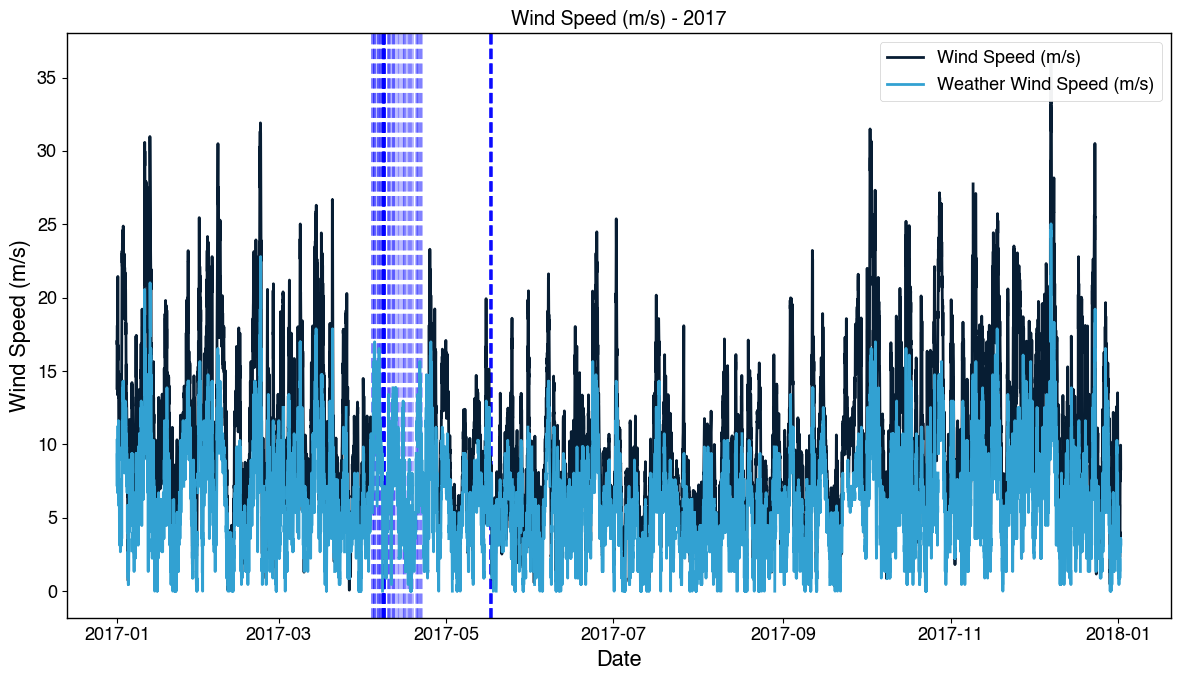

In [11]:
common_index = ts_wd.index.intersection(ts_tt_res_17.index)

df1 = ts_wd.loc[common_index]
df2 = ts_tt_res_17.loc[common_index]

# Step 3: Find timestamps where both have NaN in Wind_ms
both_nan_mask = df1['Wind Speed (m/s)'].isna() & df2['Wind_ms'].isna()

# Step 4: Extract those timestamps into a DataFrame
shared_nan_df = pd.DataFrame({'Timestamp': common_index[both_nan_mask]})

#plot shared NaN timestamps
plt.figure(figsize=(12,7))
# Draw vertical lines for missing data
for t in shared_nan_df['Timestamp']:
    plt.axvline(x=t, color='blue', linestyle='--', alpha=0.3)
plt.plot(ts_tt_res_17.index, ts_tt_res_17['Wind_ms'], label='Wind Speed (m/s)')
plt.plot(ts_wd.index, ts_wd['Wind Speed (m/s)'], label='Weather Wind Speed (m/s)')

plt.title('Wind Speed (m/s) - 2017')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [49]:
print(f' There are {shared_nan_df.shape[0]} timestamps where both datasets have NaN values in Wind_ms')

ts_tt_res_17.loc[shared_nan_df['Timestamp'], 'Wind_ms'].head()

 There are 65 timestamps where both datasets have NaN values in Wind_ms


Timestamp
2017-04-03 21:30:00   NaN
2017-04-04 03:00:00   NaN
2017-04-04 13:30:00   NaN
2017-04-04 14:30:00   NaN
2017-04-04 18:30:00   NaN
Name: Wind_ms, dtype: float64

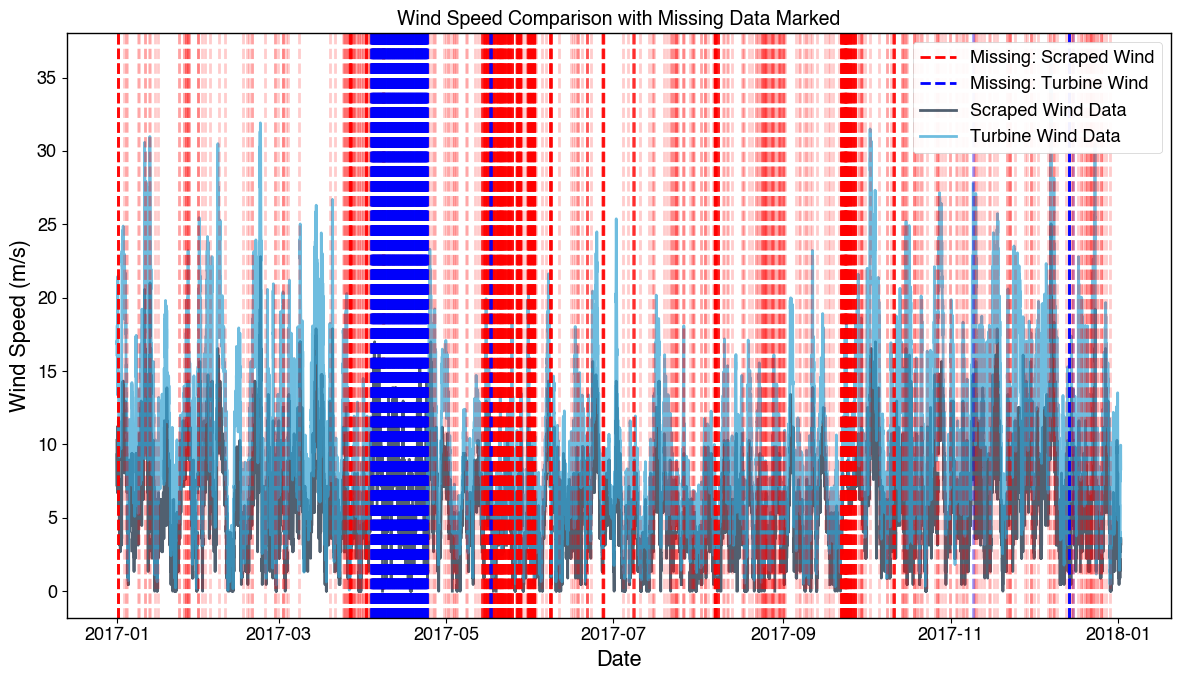

In [13]:
import matplotlib.lines as mlines

missing_df1 = df1['Wind Speed (m/s)'].isna()
missing_df2 = df2['Wind_ms'].isna()

plt.figure(figsize=(12,7))

plt.plot(df1.index, df1['Wind Speed (m/s)'], label='Scraped Wind Data', alpha=0.7)
plt.plot(df2.index, df2['Wind_ms'], label='Turbine Wind Data', alpha=0.7)

# Add vertical lines for missing values in scraped wind data
for t in df1.index[missing_df1]:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.2)

# Add vertical lines for missing values in turbine wind data
for t in df2.index[missing_df2]:
    plt.axvline(x=t, color='blue', linestyle='--', alpha=0.2)

red_line = mlines.Line2D([], [], color='red', linestyle='--', label='Missing: Scraped Wind')
blue_line = mlines.Line2D([], [], color='blue', linestyle='--', label='Missing: Turbine Wind')

# Add legend
plt.title('Wind Speed Comparison with Missing Data Marked')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend(handles=[red_line, blue_line] + plt.gca().lines[:2])  # legend for lines + dummy markers
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
print(f"missing data in scraped wind data: {missing_df1.sum()}")
print(f"missing data in turbine wind data: {missing_df2.sum()}")

missing data in scraped wind data: 986
missing data in turbine wind data: 1012


# Power Curve

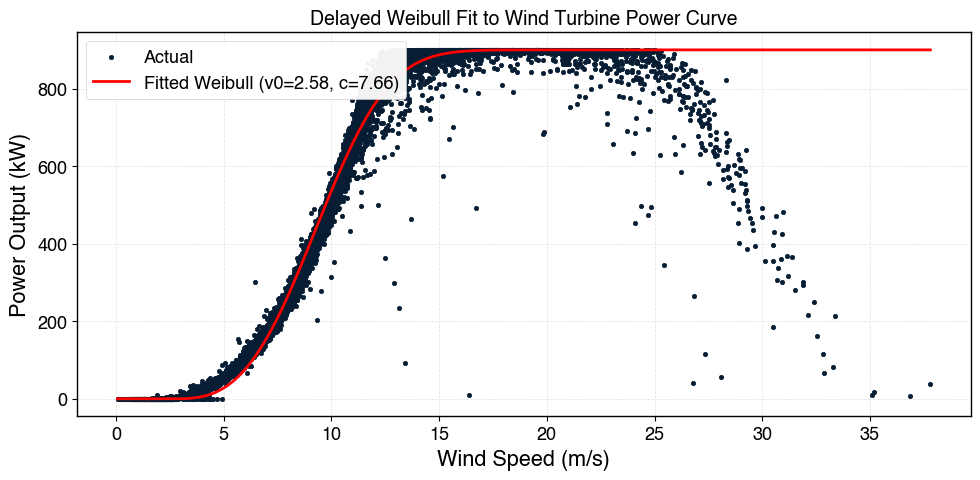

(np.float64(2.583001279343198), np.float64(7.664525045028845))

In [69]:
from scipy.optimize import curve_fit

def delayed_weibull(v:float, v0:float, c:float, pr:float):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power


#remove nan values and convert to values
df_model = load_data(PROCESSED_DATASET_PATH/'power_curve_analysis.csv')
df_model = df_model.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])

# # filter out above 895 wind speed
# df_model = df_model[(df_model['Power_kw'] < 895) & (df_model['Setpoint_kw'] == 900)]

wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and c
initial_guess = [2.7, 6.5]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, c: delayed_weibull(v, v0, c, pr=900), wind, power, p0=initial_guess)

# Predicted values using fitted parameters
v0_fit, c_fit = popt
predicted_power = delayed_weibull(wind, v0_fit, c_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)

predicted_sorted = delayed_weibull(v_sorted, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, label='Actual', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Wind Turbine Power Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

In [70]:
# Check Score of Fit

df_compare = pd.DataFrame({
    'Wind Speed (m/s)': wind,
    'Power Output (kW)': power,
    'Predicted Power Output (kW)': predicted_power
})
df_compare['Residuals'] = df_compare['Power Output (kW)'] - df_compare['Predicted Power Output (kW)']
df_compare['Residuals'] = df_compare['Residuals'].abs()

r_score = r2_score(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
rmse = root_mean_squared_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
mae = mean_absolute_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
mse = mean_squared_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])

df_metrics = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE', 'MSE'],
    'Value': [r_score, rmse, mae, mse]
})

df_metrics.head()

,Metric,Value
0,R^2,0.976163
1,RMSE,51.766336
2,MAE,25.017953
3,MSE,2679.753505


In [71]:
_v_cut_in = df_model[(df_model.loc[:, 'Power_baseline'] >= 10.)].loc[:, 'Wind_speed_baseline'].quantile(0.1) # 5% quantile minimum speed
_v_cut_out = df_model[df_model['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.95)

print(f"minimum wind speed for power production: {_v_cut_in:.2f} m/s")
print(f"maximum wind speed for power production: {_v_cut_out:.2f} m/s")

minimum wind speed for power production: 5.12 m/s
maximum wind speed for power production: 21.25 m/s


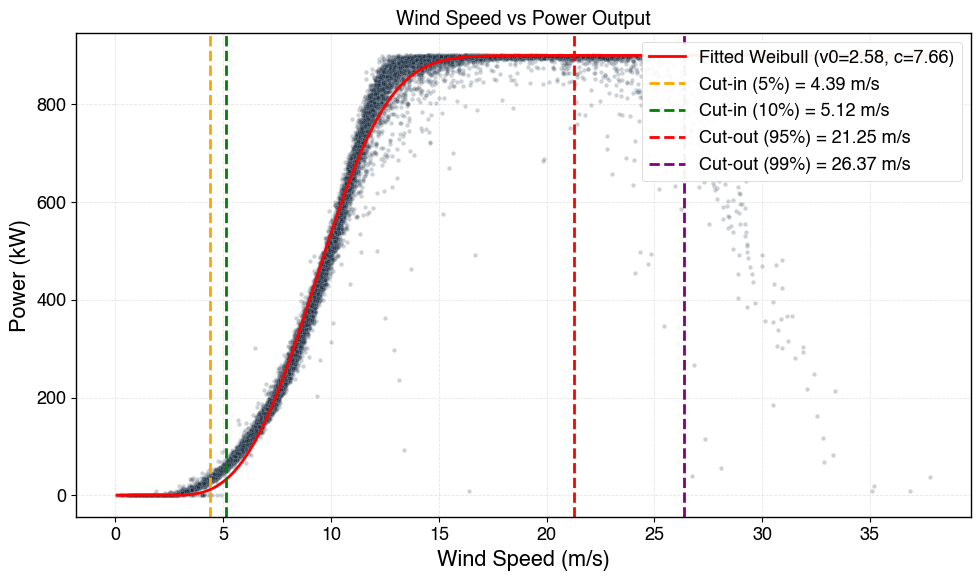

In [77]:
# Filter out rows with missing data
df_plot = df_model.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])

# Compute both quantiles for cut-in and cut-out
cutin_05 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.05)
cutin_10 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.10)
cutout_95 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.95)
cutout_99 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.99)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='Wind_speed_baseline', y='Power_baseline', alpha=0.2, s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')

# Draw cut-in / cut-out lines
plt.axvline(cutin_05, color='orange', linestyle='--', label=f'Cut-in (5%) = {cutin_05:.2f} m/s')
plt.axvline(cutin_10, color='green', linestyle='--', label=f'Cut-in (10%) = {cutin_10:.2f} m/s')
plt.axvline(cutout_95, color='red', linestyle='--', label=f'Cut-out (95%) = {cutout_95:.2f} m/s')
plt.axvline(cutout_99, color='purple', linestyle='--', label=f'Cut-out (99%) = {cutout_99:.2f} m/s')

# Labels and legend
plt.title('Wind Speed vs Power Output')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Result
This broadly follow the typical cut in and cut off speed of around 25 m/s and cut in speed around 3-4 m/s

[Wikipedia Source](https://en.wikipedia.org/wiki/Wind_turbine_design#:~:text=A%20wind%20turbine%20must%20produce,power%20has%20to%20be%20limited.)

# Filling NaN Wind Speed Data

In [62]:
ts_combined_2017 = ts_tt_res_17.merge(
    ts_wd['Wind Speed (m/s)'],
    left_index=True,
    right_index=True,
    how='left'
)

ts_combined_2017.rename(
    columns={
        'Wind Speed (m/s)': 'Scrape_wind_ms',
        'Wind_ms': 'Baseline_wind_ms'},
    inplace=True
)

ts_combined_2017.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms
Timestamp,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,NaN
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15


In [83]:
# ts_combined_2017.query('Baseline_wind_ms > 25')[['Power_kw','Setpoint_kw','Baseline_wind_ms','Scrape_wind_ms']].head(20)
ts_combined_2017.query('Scrape_linear_scaled_wind_ms > 25')[['Power_kw','Setpoint_kw','Baseline_wind_ms','Scrape_linear_scaled_wind_ms']].head(20)

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_linear_scaled_wind_ms
Timestamp,,,,
2017-01-11 02:00:00,453.642857,900.0,29.953333,28.913139
2017-01-11 02:30:00,453.033333,900.0,29.543333,29.496315
2017-01-11 03:00:00,470.961538,900.0,30.583333,25.944244
2017-01-11 03:30:00,513.952381,900.0,29.000000,25.347815
2017-01-13 01:00:00,431.280000,900.0,30.343333,26.540674
2017-01-13 01:30:00,394.100000,900.0,29.683333,28.913139
2017-01-13 02:00:00,402.633333,900.0,28.900000,30.092744
2017-01-13 02:30:00,572.333333,900.0,28.400000,28.913139
2017-01-13 03:00:00,648.833333,900.0,27.816667,27.720280


In [63]:
scraped_nan_initial = ts_combined_2017['Scrape_wind_ms'].isna()
baseline_nan_initial = ts_combined_2017['Baseline_wind_ms'].isna()

# Interpolate the missing values in baseline and scraped wind data
ts_combined_2017['Baseline_wind_ms'] = ts_combined_2017['Baseline_wind_ms'].interpolate(method='linear', limit=4, limit_direction='both')
ts_combined_2017['Scrape_wind_ms'] = ts_combined_2017['Scrape_wind_ms'].interpolate(method='linear', limit=4, limit_direction='both')


ts_combined_2017['scraped_interpolated'] = scraped_nan_initial & ts_combined_2017['Baseline_wind_ms'].notna()
ts_combined_2017['baseline_interpolated'] = baseline_nan_initial & ts_combined_2017['Scrape_wind_ms'].notna()

# Check if there are still NaN values
scraped_nan_final = ts_combined_2017['Scrape_wind_ms'].isna()
baseline_nan_final = ts_combined_2017['Baseline_wind_ms'].isna()

print(f"Scraped Wind NaN before interpolation: {scraped_nan_initial.sum()}")
print(f"Baseline Wind NaN before interpolation: {baseline_nan_initial.sum()}")
print("")
print(f"Scraped Wind NaN after interpolation: {scraped_nan_final.sum()}")
print(f"Baseline Wind NaN after interpolation: {baseline_nan_final.sum()}")


Scraped Wind NaN before interpolation: 987
Baseline Wind NaN before interpolation: 1012

Scraped Wind NaN after interpolation: 323
Baseline Wind NaN after interpolation: 985


## Scale Scraped Wind Data (Linear Regression)

In [64]:
# Step 1: Drop rows with missing values for training
df_clean = ts_combined_2017.dropna(subset=['Scrape_wind_ms', 'Baseline_wind_ms'])

# Step 2: Fit linear regression
X = df_clean[['Scrape_wind_ms']]
y = df_clean['Baseline_wind_ms'].values

model = LinearRegression()
model.fit(X, y)

# Step 3: Apply model to full dataset (including rows with NaNs in baseline)
ts_combined_2017['Scrape_linear_scaled_wind_ms'] = np.nan  # initialize with NaNs
mask = ts_combined_2017['Scrape_wind_ms'].notna()
ts_combined_2017.loc[mask, 'Scrape_linear_scaled_wind_ms'] = model.predict(ts_combined_2017.loc[mask, ['Scrape_wind_ms']])

# Step 4: Optional - Evaluate model performance
y_pred = model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Linear Regression Correction:")
print(f"MAE: {mae:.2f} m/s")
print(f"MSE: {mse:.2f} m²/s²")
print(f"RMSE: {rmse:.2f} m/s")
print(f"R² Score: {r2:.2f}")

Linear Regression Correction:
MAE: 2.26 m/s
MSE: 8.56 m²/s²
RMSE: 2.92 m/s
R² Score: 0.71


## Filling Logic

If Baseline_wind_ms is missing → use Scrape_linear_scaled_wind_ms instead.

Create a new column (e.g., `Wind_data_source`) with values:
- "baseline" if baseline data was used
- "scraped" if scaled scraped data was used

Calculate power when power baseline is NaN 
- if wind speed is greater v_min but power is NaN that means the turbine is purposely turned off so we dont calculate it and put NaN instead


### Wind Speed Filling

In [66]:
ts_combined_2017['Final_wind_ms'] = ts_combined_2017['Baseline_wind_ms']
mask = ts_combined_2017['Baseline_wind_ms'].isna()

# Fill missing with corrected scraped wind
ts_combined_2017.loc[mask, 'Final_wind_ms'] = ts_combined_2017.loc[mask, 'Scrape_linear_scaled_wind_ms']

# Track data source
ts_combined_2017['Wind_data_source'] = 'baseline'
ts_combined_2017.loc[mask, 'Wind_data_source'] = 'scraped'

In [67]:
ts_combined_2017.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source
Timestamp,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline


### Power filling

In [85]:
def delayed_weibull(v:float, pr:float, v0:float = 2.5826558689219445, c:float = 7.663614962833285):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power

# Calculate power output using the Weibull model
ts_combined_2017['Predicted_power_kw'] = delayed_weibull(ts_combined_2017['Final_wind_ms'], pr=900)

# Final_power_kw initialize with baseline power
ts_combined_2017['Final_power_kw'] = ts_combined_2017['Power_kw']

# Define where it's safe to fill: no curtailment or shut-down
fill_mask = ts_combined_2017['Power_kw'].isna() & (
    ts_combined_2017['Baseline_wind_ms'].isna()   # can't assess → OK to fill
    | (ts_combined_2017['Baseline_wind_ms'] < _v_cut_in)   # not enough wind
    # | (ts_combined_2017['Baseline_wind_ms'] > _v_cut_out)    # above cut-out (optional: derating)
)

# Fill with predicted power where appropriate
ts_combined_2017.loc[fill_mask, 'Final_power_kw'] = ts_combined_2017.loc[fill_mask, 'Predicted_power_kw']

# Add power data source flag
ts_combined_2017['Power_data_source'] = 'baseline'
ts_combined_2017.loc[fill_mask, 'Power_data_source'] = 'predicted'

ts_combined_2017.loc[
    ts_combined_2017['Power_kw'].isna() &
    ts_combined_2017['Baseline_wind_ms'].between(_v_cut_in, _v_cut_out),
    'Power_data_source'
] = 'not_operating'

In [86]:
ts_combined_2017.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source,Predicted_power_kw,Final_power_kw,Power_data_source
Timestamp,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.539133,889.766667,baseline
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.305704,893.266667,baseline
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.370495,897.633333,baseline
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.971498,899.966667,baseline
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.481853,900.000000,baseline


| Column Name                    | Data Type  | Unit | Description                                                                  |
| ------------------------------ | ---------- | ---- | ---------------------------------------------------------------------------- |
| `Timestamp`                    | `datetime` | -    | Timestamp of the observation (30-minute frequency).                          |
| `Power_kw`                     | `float`    | kW   | Actual power output from the turbine (baseline telemetry).                   |
| `Setpoint_kw`                  | `float`    | kW   | Target or allowed power output set by turbine controller or grid signal.     |
| `Baseline_wind_ms`             | `float`    | m/s  | Measured wind speed from the turbine sensor (baseline).                      |
| `Scrape_wind_ms`               | `float`    | m/s  | Wind speed scraped from a weather data source.                               |
| `scraped_interpolated`         | `boolean`  | -    | `True` if the scraped wind value was filled via short-gap interpolation.     |
| `baseline_interpolated`        | `boolean`  | -    | `True` if the baseline wind value was filled via short-gap interpolation.    |
| `Scrape_linear_scaled_wind_ms` | `float`    | m/s  | Scraped wind corrected using a linear regression model.                      |
| `Final_wind_ms`                | `float`    | m/s  | Final selected wind speed (baseline or corrected scraped).                   |
| `Wind_data_source`             | `string`   | -    | Source of `Final_wind_ms`: `"baseline"` or `"scraped"`.                      |
| `Predicted_power_kw`           | `float`    | kW   | Power estimated from `Final_wind_ms` using a Weibull power model.            |
| `Final_power_kw`               | `float`    | kW   | Final selected power: either `Power_kw` or filled from `Predicted_power_kw`. |
| `Power_data_source`            | `string`   | -    | Source of `Final_power_kw`: `"baseline"`, `"predicted"`, or `"turbine_off"`. |
| `Energy_kWh`                   | `float`    | kWh  | Energy output during the 30-minute interval (`Final_power_kw × 0.5`).        |


# Power to Energy

$$
\boxed{\text{Energy (kWh)} = \text{Power (kW)} \times \text{Time (hours)}}
$$


In [100]:
ts_combined_2017['Energy_kwh'] = ts_combined_2017['Final_power_kw'] * 0.5 # cause our data is 30 min

# Check for Final Missing Value

In [92]:
# check final NaN values
print(f'Final NaN values in Final_wind_ms: {ts_combined_2017["Final_wind_ms"].isna().sum()}')
print(f'Final NaN values in Final_power_kw: {ts_combined_2017["Final_power_kw"].isna().sum()}')


Final NaN values in Final_wind_ms: 16
Final NaN values in Final_power_kw: 61


In [94]:
# Check Where the missing value is
ts_combined_2017[ts_combined_2017['Final_power_kw'].isna()][['Power_kw','Setpoint_kw','Baseline_wind_ms','Scrape_linear_scaled_wind_ms']].head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_linear_scaled_wind_ms
Timestamp,,,,
2017-01-12 18:00:00,NaN,900.0,23.556667,14.691604
2017-01-12 19:00:00,NaN,900.0,23.820000,18.840104
2017-01-12 19:30:00,NaN,900.0,26.503333,20.616139
2017-01-12 20:00:00,NaN,900.0,25.410000,21.212569
2017-01-12 21:30:00,NaN,900.0,25.470000,22.988604


In [101]:
ts_combined_2017.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source,Predicted_power_kw,Final_power_kw,Power_data_source,Energy_kwh
Timestamp,,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.539133,889.766667,baseline,444.883333
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.305704,893.266667,baseline,446.633333
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.370495,897.633333,baseline,448.816667
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.971498,899.966667,baseline,449.983333
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.481853,900.000000,baseline,450.000000


In [102]:
# Output the final DataFrame
ts_combined_2017.to_csv(PROCESSED_DATASET_PATH/'250411_turbine_telemetry_dataset_v1.csv', index=True)

# Summary

Data Cleaning:
- Short Missing Period Impute the data (interpolate)
- Long Missing Period Use scraped data
- 

Data Analysis:
- Sanity Check (when is curtailment happening and such)